# Tomancak et al Drosophila Data with GPy and Pandas

#### presented at the EBI BioPreDyn Course 'The Systems Biology Modelling Cycle'

### Neil Lawrence, 12th May 2014 with help from Marta Milo for the Bioconductor Portion

#### Updated 18th March 2015 for latest GPy edition.

### Introduction

In this demonstration we are going to load pre-processed Affymetrix time series data. The data is pre-processed in R using bioconductor. The results are then loaded into a python for further analysis with a Gaussian process.

The analysis we are going to do is to check whether any given set of replicates is 'valid'. In other words, were the replicates drawn from the same Gaussian process. To do this we will fit two Gaussian process models, one which assumes that the replicates are independent and one that assumes that they are drawn from the same process. We will evaluate the likelihood of each. The result could be used in a likelihood ratio test.

### Preparing the Environment

Firstly we load in the data set by downloading `cel` files if the analyzed files aren't already present on the disk. We load in `rmagic` if that data isn't present to do the preprocessing in the R PUMA package from bioconductor.

In [1]:
import os
import numpy as np
import GPy
import pods
%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10.0, 4.0)

### Use Bioconductor for Processing

Now we process the `cel` files using the PUMA package from bioconductor in R. This step can take a long time. The R code checks whether the preprocessed results are present and skips the processing of the `cel` files if they are. If you want to run the processing from scratch, delete any processed results stored in `datapath` and set the variable in the next box `process_data_in_R` to `True`.

In [2]:
# This downloads cel files if they are not present. 
# These cel files would be needed if you want to do 
# the full Bioconductor analysis below.
process_data_in_R = False
if process_data_in_R:
    %load_ext rmagic
    datapath = os.path.join(pods.datasets.data_path, 'fruitfly_tomancak')
    # download the original cel files and prepare to process!
    data_set = 'fruitfly_tomancak_cel_files'
    if not pods.datasets.data_available(data_set):
        data = pods.datasets.download_data(data_set)
else:
    # download the puma-processed affymetrix data.
    data = pods.datasets.fruitfly_tomancak()

This portion of the code will do the PUMA analysis of the gene
expression data in R. To run it needs to have the cel files
from <a href="ftp://ftp.fruitfly.org/pub/embryo_tc_array_data/">this fruitfly.org FTP server</a>. The code above dowloads all the `cel` files and stores them in the path given by `datapath`. 

In [ ]:
%%R -i datapath
returnpath <- getwd()
setwd(datapath)
if(!file.exists("tomancak_exprs.csv")) {
    source("http://www.bioconductor.org/biocLite.R")
    biocLite("puma")
    library(puma)
    print("Processing data with PUMA")
    expfiles <- c(paste("embryo_tc_4_", 1:12, ".CEL", sep=""), paste("embryo_tc_6_", 1:12, ".CEL", sep=""), paste("embryo_tc_8_", 1:12, ".CEL", sep=""))
    library(puma)
    drosophila_exp_set <- justmmgMOS(filenames=expfiles, celfile.path=datapath)
    pData(drosophila_exp_set) <- data.frame("time.h" = rep(1:12, 3), row.names=rownames(pData(drosophila_exp_set)))    
    write.reslts(drosophila_exp_set, file='tomancak')
}
else {
    print("Processed data found on disk.")
}
setwd(returnpath)

### Read Gene Expression Data into Pandas Dataframe

Once the analysis is complete, the results are stored in the file `tomancak_exprs.csv`. To save you doing the full analysis, we can download a pre-processed version of this file using this command.

In [4]:
data = pods.datasets.fruitfly_tomancak()
X = data['X']
Y = data['Y']

The gene expression data is now loaded into the python environment. We have made use of `pandas` a python library for handling data structures. It provides us with a `DataFrame` object which gives some functionality similar to that of `R` for basic analysis.

### Are these Replicates Really Valid?

Next we are going to write a couple of python functions that allow us to do some simple processing of the gene expression data. The idea will be to see if the data is best modelled through a series of *identical* Gaussian processes, or through series of *independent* Gaussian processes. 

In [5]:
def fit_probe(id, independent=False):
    """Fit a set of probe repeats as either independent or correlated."""
    
    # set up the covariance function.
    lengthscale = 2.
    if independent:
        kern = GPy.kern.RBF(1,lengthscale=lengthscale)**GPy.kern.Coregionalize(1,3, rank=0)
        name = 'independent gp'
    else:
        kern = GPy.kern.RBF(1,lengthscale=lengthscale)**GPy.kern.Coregionalize(1,3, rank=1)
        kern.coregion.W[0] = 1.
        kern.coregion.W[1] = 1.
        kern.coregion.W[2] = 1.
        kern.coregion.W.constrain_fixed()
        name = 'joint gp'

    kern += GPy.kern.Bias(2)
    
    m = GPy.models.GPRegression(X, Y[id][:, None], kern)
    m.name = name
    m.optimize(messages=True)
    return m

We'd like to display the model fits. The `GPy` software allows us to select which data to plot from the model. Below there's a function for plotting the data associated with each repliacte alongside the fit.

In [6]:
import matplotlib.pyplot as plt
from IPython.display import display

def show_model_fit(m):
    display(m)
    fig, ax = plt.subplots(1, 3, sharex=False,sharey=True, figsize=(12, 3.5))
    symbols = ['x', 'x', 'x']
    replicate_str = 'replicate {}'
    #linecolors = [(1.,0.,0.), (0., 1., 0.), (0., 0., 1.)]
    mi, ma = np.inf, -np.inf
    for replicate in range(3):
        # Plot the result without noise (trying to estimate underlying gene expression)
        which_data_rows=np.nonzero(X[:,1]==replicate)                         
        data_symbol=symbols[replicate]
        pl = m.plot_f(ax=ax[replicate], fixed_inputs=[(1, replicate)], 
                      which_data_rows=which_data_rows,
                      data_symbol=data_symbol,
                      )
        ax[replicate].plot(m.X[which_data_rows, 0].flatten(), 
                           m.Y[which_data_rows].flatten(), 
                           data_symbol, c='k', mew=1.5,
                          )
        ax[replicate].text(.98, .98, replicate_str.format(replicate), ha='right', va='top',
                          transform=ax[replicate].transAxes)
        _mi, _ma = ax[replicate].get_ylim()
        if _mi < mi: mi = _mi
        if _ma > ma: ma = _ma
    for _ax in ax:
        _ax.set_ylim(mi, ma)
    ax[0].set_ylabel('gene expression [arbitrary]')
    ax[1].set_xlabel('time [hrs]')
    fig.text(0.5,1, m.name, ha='center', va='top', size=22, 
             bbox=dict(facecolor='white', edgecolor='k', lw=.4, boxstyle='round'), clip_on=False)
    fig.tight_layout(rect=(0,0,1,1))
    #GPy.plotting.matplot_dep.base_plots.align_subplots(1, 3, xlim=ax[0].get_xlim(), ylim=ax[0].get_ylim())
        
def fit_and_display(probe_id):
    mc = fit_probe(probe_id, independent=True)
    mi = fit_probe(probe_id, independent=False)
    show_model_fit(mc)
    show_model_fit(mi)
    return mc, mi

Now let's fit each of the two models to a given probe id. First we select a probe_id where the correspondence between the repeats is not very strong (even if it's there).

independent_gp.,value,constraints,priors
sum.mul.rbf.variance,0.481622218702,+ve,
sum.mul.rbf.lengthscale,2.22933167662,+ve,
sum.mul.coregion.W,[],,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,13.0169956879,+ve,
Gaussian_noise.variance,2.36743656163,+ve,


joint_gp.,value,constraints,priors
sum.mul.rbf.variance,1.72364735571,+ve,
sum.mul.rbf.lengthscale,3.33381017053,+ve,
sum.mul.coregion.W,"(3, 1)",fixed,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,15.5420403587,+ve,
Gaussian_noise.variance,1.9462549958,+ve,


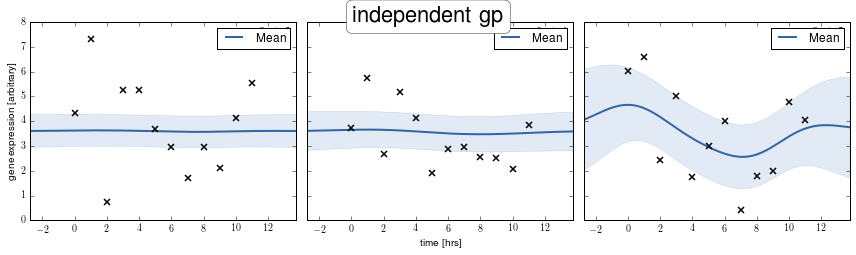

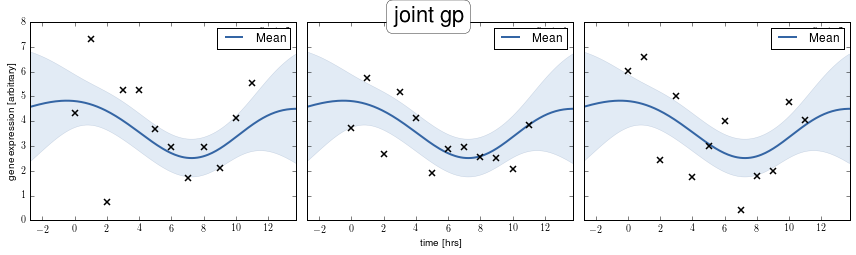

In [7]:
mc, mi = fit_and_display('141201_at')

Viewing the results here, for the independent model two of the fits adjudge there to be *no signal*. The constrained model shares information across the fits and can therefore determine better parameters. We can compute the ratio of the likelihods given:

In [8]:
print mc.log_likelihood() - mi.log_likelihood()

-2.69115843672


As a second gene, we consider `141200_at`. This gene turns out to have a more consistent response across the three repeats.

independent_gp.,value,constraints,priors
sum.mul.rbf.variance,2.09052725197,+ve,
sum.mul.rbf.lengthscale,2.15096358834,+ve,
sum.mul.coregion.W,[],,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,47.3972473373,+ve,
Gaussian_noise.variance,0.583374639802,+ve,


joint_gp.,value,constraints,priors
sum.mul.rbf.variance,1.6733336308,+ve,
sum.mul.rbf.lengthscale,2.25933047866,+ve,
sum.mul.coregion.W,"(3, 1)",fixed,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,47.024207916,+ve,
Gaussian_noise.variance,0.466843134315,+ve,


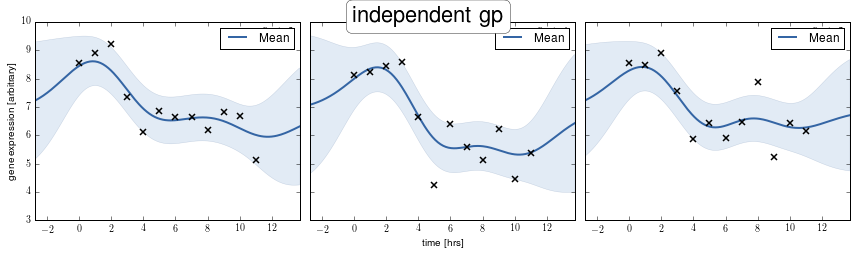

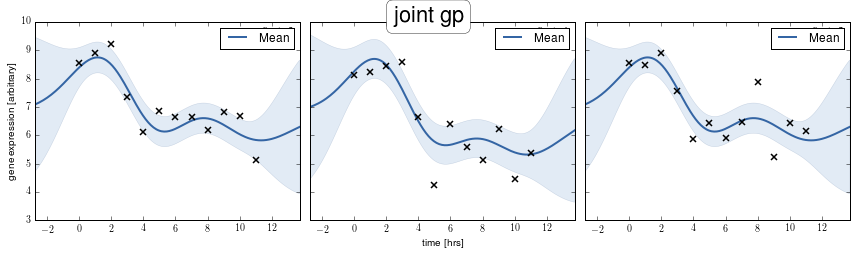

In [9]:
mc, mi = fit_and_display('141200_at')


Naturally, the likelihood still favours the constrained model. 

### Outlier Detection

The above model used a Gaussian noise to fit the data (i.e. it assumed that gene expression has a log-normally distributed noise). In the next example we will relax this assumption and use the *Laplace approximation* to fit a model with a Student-t noise model (degrees of freedom 5). This makes the analysis less sensitive to outliers.

In [10]:
def fit_probe(id, independent=False):
    """Fit a set of probe repeats as either independent or correlated."""
    
    # set up a likelihood function, Student-t with 5 degress of freedom.
    likelihood = GPy.likelihoods.StudentT(deg_free=5)
    # use the Laplace approximation for inference.
    inference = GPy.inference.latent_function_inference.laplace.Laplace()

    # set up the covariance function as before.
    lengthscale = 3.3
    if independent:
        kern = GPy.kern.RBF(1,lengthscale=lengthscale)**GPy.kern.Coregionalize(1,3, rank=0)
        name = 'independent gp'
    else:
        kern = GPy.kern.RBF(1,lengthscale=lengthscale)**GPy.kern.Coregionalize(1,3, rank=1)
        kern.coregion.W[0] = 1.
        kern.coregion.W[1] = 1.
        kern.coregion.W[2] = 1.
        kern.coregion.W.constrain_fixed()
        name = 'joint gp'

    kern += GPy.kern.Bias(2)
    
    m = GPy.core.GP(X, Y[id][:, None], likelihood=likelihood, inference_method=inference, kernel=kern, name=name)
    m.optimize(messages=True)
    return m

independent_gp.,value,constraints,priors
sum.mul.rbf.variance,9.02815616863e-05,+ve,
sum.mul.rbf.lengthscale,1.23195228302e-15,+ve,
sum.mul.coregion.W,[],,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,12.0830497819,+ve,
Student_T.t_scale2,1.40327776475,+ve,
Student_T.deg_free,241230.532918,+ve,


joint_gp.,value,constraints,priors
sum.mul.rbf.variance,1.72362972802,+ve,
sum.mul.rbf.lengthscale,3.33382235324,+ve,
sum.mul.coregion.W,"(3, 1)",fixed,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,15.5408413253,+ve,
Student_T.t_scale2,1.9462960868,+ve,
Student_T.deg_free,197085.121973,+ve,


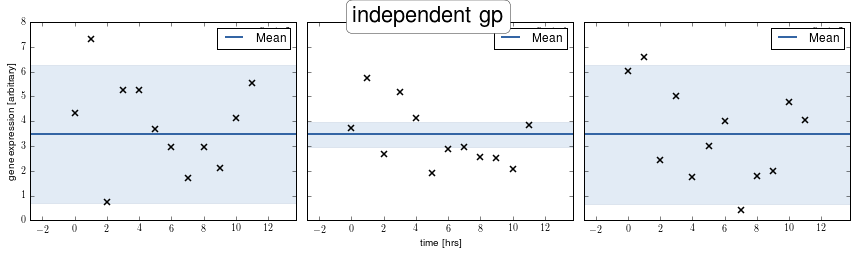

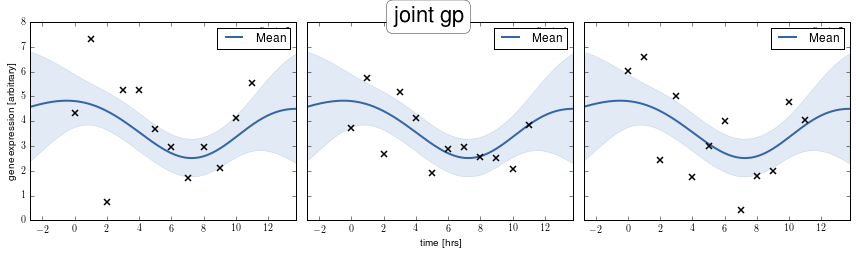

In [11]:
mc, mi = fit_and_display('141201_at')

 /home/maxz/Documents/gpy/GPy/inference/latent_function_inference/laplace.py:225: UserWarning:Not perfect mode found (f_hat). difference: 0.000577364331264, iteration: 30 out of max 30
 /home/maxz/Documents/gpy/GPy/inference/latent_function_inference/laplace.py:229: UserWarning:f_hat now fine again. difference: 6.92839415066e-05, iteration: 8 out of max 30


independent_gp.,value,constraints,priors
sum.mul.rbf.variance,825.413920886,+ve,
sum.mul.rbf.lengthscale,2.15105493755,+ve,
sum.mul.coregion.W,[],,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,47.5224357048,+ve,
Student_T.t_scale2,0.583366971663,+ve,
Student_T.deg_free,25080.1532746,+ve,


joint_gp.,value,constraints,priors
sum.mul.rbf.variance,1.67355438177,+ve,
sum.mul.rbf.lengthscale,2.25937641453,+ve,
sum.mul.coregion.W,"(3, 1)",fixed,
sum.mul.coregion.kappa,"(3,)",+ve,
sum.bias.variance,47.0055298343,+ve,
Student_T.t_scale2,0.466869541971,+ve,
Student_T.deg_free,649705.042094,+ve,


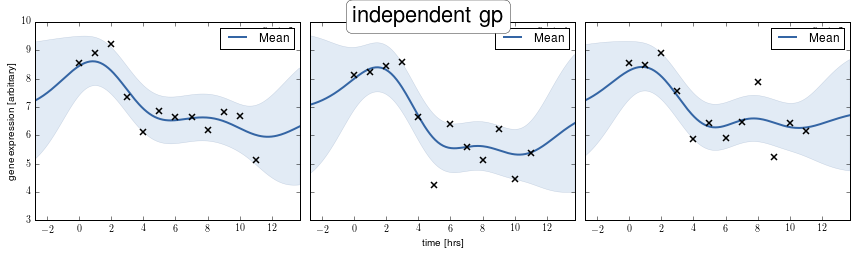

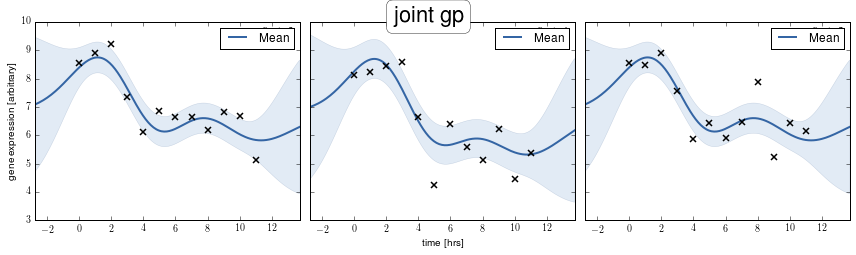

In [12]:
mc, mi = fit_and_display('141200_at')

### Is a Gene Differentially Expressed?

When testing whether the replicates are valid, we can reverse the question and ask whether two *different* genes are differentially expressed.  <a href="http://online.liebertpub.com/doi/abs/10.1089/cmb.2009.0175">Stegle et al</a> (in a more sophisticated way than our simple analysis) show how this idea can be used to determine whether a gene has been differentially expressed. In recent work with Paul Heath and Sura Zaki Al Rashir we are combining such differential expression studies with multiple conditions giving tests to determine under which of the conditions the genes are differentially expressed.

#### work funded by the BioPreDyn and RADIANT projects.